This notebook contains code for making the dataset for both semantic segmentation and nucleus detection and localization. 

In [5]:
import numpy as np 
import os 
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import misc

/home/suhaila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/suhaila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/suhaila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


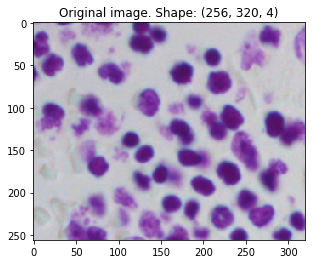

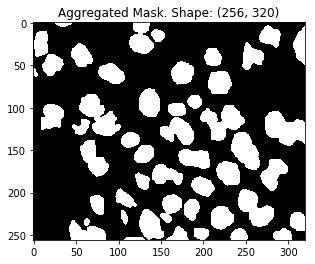

In [7]:
#Getting a list of all the image directories
list_of_images = glob("stage1_train/*/")

#Visualizing a random image and the masks

ch = np.random.randint(0,len(list_of_images))

folder_name_image = list_of_images[ch]+'images/'
image_path = glob(folder_name_image+'*.png')[0]

folder_name_mask =  list_of_images[ch]+'masks/'
list_of_masks = glob(folder_name_mask+'*.png')

#The masks are provided for each individual nucleus, i.e, if there are 5 nuclei in an image, there are 5 individual
#masks provided in the original downloaded dataset

#Adding the masks of all the individual nucleus masks to create a single mask showing all the nuclei 
#Loading the first mask 
mask_img = misc.imread(list_of_masks[0])

#And adding the remaining masks to that 
for mask in list_of_masks[1:]: 
    mask_img +=misc.imread(mask)

#Visualize
image = misc.imread(image_path)
plt.imshow(image, cmap = 'gray')
plt.title('Original image. Shape: '+str(image.shape))
plt.show()

plt.imshow(mask_img, cmap = 'gray')
plt.title('Aggregated Mask. Shape: '+str( mask_img.shape))
plt.show()

# Making Dataset

In [9]:
#Taking 256x256 crops to make the training set and get bounding boxes 

def make_dataset(folder_name_with_all_img_folders):
    list_of_images = glob(folder_name_with_all_img_folders)
    
    #Training input
    X = np.zeros((len(list_of_images),256,256,3))
    #Training label masks - ground truth for semantic segmentation
    Y = np.zeros((len(list_of_images),256,256,1))
    
    #Ground truth dataset for bounding box prediction and classification 
    #Size of subcell 
    subcell_size = 8 
    subcell_count = 256/subcell_size
    D = np.zeros((len(list_of_images),int(subcell_count),int(subcell_count),5))
    
    #Iterating through to add the data
    k = 0 

    for img in list_of_images: 
    
        #########################################################################################################
        
        #Getting the training input image
        folder_name_image = img+'images/'
        image_path = glob(folder_name_image+'*.png')[0]
        orig_img = misc.imread(image_path)
    
        
        #Getting the masks for the image
        folder_name_mask =  img +'masks/'
        list_of_masks = glob(folder_name_mask+'*.png')
        num_instances = len(list_of_masks)
        
        
        #For random 256x256 crops 
        start_row = np.random.randint(0,orig_img.shape[0]-255)
        start_col = np.random.randint(0,orig_img.shape[1]-255)

        #########################################################################################################
        
                                                #Making bounding box + class score dataset [D]
            
        '''
        The 256 x 256 image is divided into 8x8 subcells. Each 8x8 subcell is assigned a class score of 1 if the center 
        of a nucleus falls in it. The final dataset will then be 32x32 images with 5 channels. The first channel is the 
        class score and the following four channels are the bounding box co-ordinates : center x, center y, height, width.
        
        Notes: 
               x is the vertical axis co-ordinate describing the rows
               y is the horizontal axis co-ordinate describing the columns 
               
               T is the temporary array that gets updated as the sliding window is moved through the image to make the 
               dataset. This is reset for every image. At the end of each loop iteration,it is added to the final dataset D. 
        '''
        
        #########################################################################################################
               
                        #To calculate the position of the nuclei in the temp array based on its coordinates
        
        def find_cell_and_update(x, y, h, w , t, size = 8, count = 32):
            
            '''
            This function accepts the coordinates of the center of the nuclei and the width and height of the
            bounding box, encodes them and places them in the correct spot on the temp array. All the bounding 
            box parameters are encoded as a fraction of the subcell size (8), i.e., their relative position within the
            subcell.
            
            Input: 
                    x - center x coordinate
                    y - center y cordinate
                    h - height of the nuclei
                    w - width of the nuclei 
                    t - temp array that gets added to the final dataset
                    size - size of subcell
                    count - number of subcells based on the size; count = 256/size
            
            Output:
                    Returns the temp array t to be stored in the final dataset. 
            
            Note: 
                    x is vertical coord and y is horizontal coord
            '''
           
            t = np.zeros((count,count,5))
            
            nx = 0 
            
            #Outer loop for vertical slide 
            for outer in range(0,count): 
                ny = 0 
                
                #Inner loop for horizontal slide 
                for inner in range(0,count): 
                    startx = nx 
                    starty = ny 
                    endx = nx + (size-1)
                    endy = ny + (size-1)
                    if int(x) >= startx and int(x) <= endx and int(y) >= starty and int(y) <= endy:
                    
                        
                        #The nuceli center falls in the subcell 
                        t[outer, inner ,0] = 1
                        
                        #Encoding the bounding box parameters
                        width_encoded = w/256
                        height_encoded = h/256
                        x_encoded = (x - startx)/size
                        y_encoded = (y - starty)/size
                        
                        #Updating the temp array with bounding box parameters
                        t[outer,inner,1] = x_encoded
                        t[outer,inner,2] = y_encoded
                        t[outer,inner,3] = height_encoded
                        t[outer,inner,4] = width_encoded

                    else: 
                
                        t[outer, inner ,0] = 0 
                        t[outer,inner,1] = 0
                        t[outer,inner,2] = 0
                        t[outer,inner,3] = 0
                        t[outer,inner,4] = 0
                        
                    #Moving horizontally along the temp array
                    ny = ny + size
                
                #Moving horizontally along the temp array   
                nx = nx + size
                
            return t
            
       #########################################################################################################
        
                    #Populating the temporary array with class scores and encoded bounding box parameters
            
            
        #Temporary storage
        T = np.zeros((int(subcell_count), int(subcell_count),5))
    
        for inst in range(num_instances):
            current_slice = misc.imread(list_of_masks[inst])
            current_slice = current_slice.reshape(current_slice.shape[0],current_slice.shape[1],1)
            current_slice_cropped = current_slice[start_row:start_row+256, start_col: start_col+256,:]
            
            #Coordinates of the nuceli in the slice 
            rowc = np.where(current_slice_cropped!=0)[0]
            colc = np.where(current_slice_cropped!=0)[1]
            
            #If no nuclei in slice 
            if (len(rowc)==0 and len(colc)==0): 
                T+=np.zeros((int(subcell_count), int(subcell_count),5))

            else:
                
                xmin = min(rowc)
                ymin = min(colc)
                xmax = max(rowc)
                ymax = max(colc)
                
                width = ymax - ymin
                height = xmax - xmin 
                centerx = np.mean(rowc)
                centery = np.mean(colc)
                
                T+= find_cell_and_update(x = centerx, y = centery, h = height, w = width ,t =  T, size = 8, count = 32)
                
                #Sometimes the same subcell can be assigned two nuclei due to crowding so the score assigned to the cell
                #could be greater than 1. Since these represent probabilities, we need to fix that 
                
                to_fix = T[:,:,0]
                row_fix = np.where(to_fix>1)[0]
                col_fix = np.where(to_fix>1)[1]
                
                #If there is no such instance
                if(len(row_fix)==0 and len(col_fix==0)):
                    pass
                else: 
                    for fi in range(len(row_fix)): 
                        to_fix[row_fix[fi],col_fix[fi]] = 1
                        
                    #The class probability channel is fixed    
                    T[:,:,0] = to_fix
    
         
        #########################################################################################################
       
                                    #Making an aggregate mask for semantic segmentation 
        
        #Adding the masks of all the individual nucleus masks to create a single mask showing all the nuclei 
        #Loading the first mask 
        mask_img = misc.imread(list_of_masks[0])
 
        #And adding the remaining masks to that 
        for mask in list_of_masks[1:]: 
            #Training labels 
            mask_img +=misc.imread(mask)
            
        #Aggregate mask 
        mask_img = mask_img.reshape(mask_img.shape[0],mask_img.shape[1],1)
        mask_img_cropped = mask_img[start_row:start_row+256, start_col: start_col+256,0:1]
        
        
        #The input image has 4 channels, the last one for transparency. We do not include that channel in the training set 
        orig_img_cropped = orig_img[start_row:start_row+256, start_col: start_col+256,0:3]
    
        
        #########################################################################################################
                                                        
                                                        #Making dataset
        
        #Input image
        X[k,:,:,:] = orig_img_cropped
        
        #Mask data for semantic segmentation 
        Y[k,:,:,:] = mask_img_cropped
        
        #Bounding box and class score data for classification and bounding box regression
        D[k] = T[:,:,:]
        
        #########################################################################################################
        
        #Keeping track 
        if (k+1)%50==0 or k+1==len(list_of_images): 
            print('Collected '+str(k+1)+' Images')

        #Incrementing k to loop through all the image folders
        k+=1
        
    #Out of for loop 
    #Return datasets
    
    return X, Y, D

In [10]:
folder_name = "stage1_train/*/"
X,Y,D = make_dataset(folder_name)

/home/suhaila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/suhaila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/suhaila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:192: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/suhaila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:197: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Collected 50 Images
Collected 100 Images
Collected 150 Images
Collected 200 Images
Collected 250 Images
Collected 300 Images
Collected 350 Images
Collected 400 Images
Collected 450 Images
Collected 500 Images
Collected 550 Images
Collected 600 Images
Collected 650 Images
Collected 670 Images


In [11]:
#Checking if any class scores are greater than 1 as a result of two nuceli being assigned to the same subcell 
no_problem = 0
for im in range(D.shape[0]): 
    h = D[im,:,:,0]
    if len(np.where(h>1)[0])>0:
        print(np.where(h>1))
        print (im)
    else: 
        no_problem += 1
        
if(no_problem==D.shape[0]): 
    print('Success. No such instances were found.')

Success. No such instances were found.


In [12]:
print('Shape of input dataset: ',X.shape)
print('Shape of output labels (mask): ',Y.shape)
print('Shape of ground truth (bounding box + class score): ',D.shape)

Shape of input dataset:  (670, 256, 256, 3)
Shape of output labels (mask):  (670, 256, 256, 1)
Shape of ground truth (bounding box + class score):  (670, 32, 32, 5)


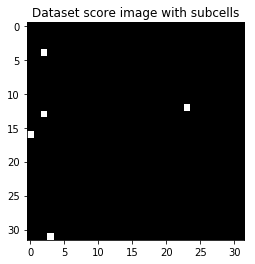

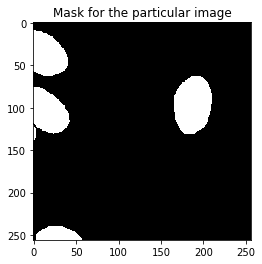

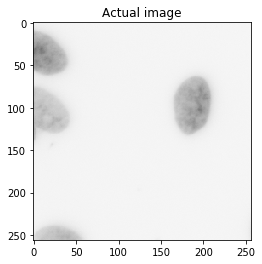

In [13]:
ch = np.random.randint(X.shape[0])

plt.imshow(D[ch,:,:,0],cmap = 'gray')
plt.title('Dataset score image with subcells')
plt.show()

plt.imshow(Y[ch,:,:,0],cmap='gray')
plt.title('Mask for the particular image')
plt.show()

plt.imshow(X[ch,:,:,:])
plt.title('Actual image')
plt.show()

Max number of ROIs:  127
Minimum number of ROIs:  0
Indices of images where there are no nuclei:  [244 272 353 389 517 549]
Indices of image with min number of nuclei:  (array([244, 272, 353, 389, 517, 549]),)
Indices of image with max number of nuclei:  (array([375]),)


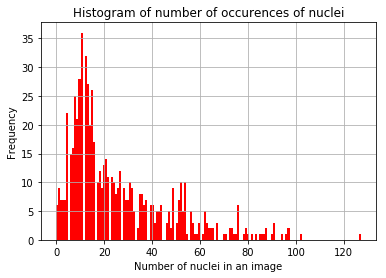

In [14]:
#Finding maximum number of occurences to fix number of region proposals 
num_i = []
for i in range(D.shape[0]): 
    num_i.append(len(np.where(D[i,:,:,0]!=0)[0]))
    
print('Max number of ROIs: ',max(num_i))
print('Minimum number of ROIs: ',min(num_i))

num_i = np.array(num_i)
#Checking if there are any images where there are no occurrences of nuclei 
#This may happen due to random cropping while making the dataset 
no_occ = np.where(num_i==0)[0]
print('Indices of images where there are no nuclei: ',no_occ)

    
print('Indices of image with min number of nuclei: ',np.where(num_i==min(num_i)))
print('Indices of image with max number of nuclei: ',np.where(num_i==max(num_i)))


plt.hist(num_i,150,color='red')
plt.title("Histogram of number of occurences of nuclei")
plt.grid()
plt.xlabel("Number of nuclei in an image")
plt.ylabel("Frequency")
plt.show()


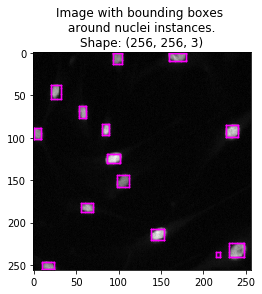

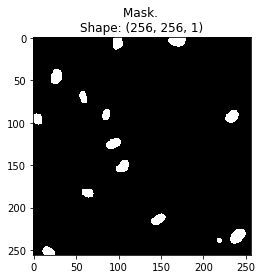

In [15]:
#Function to plot bounding boxes for all the nuclei in an image

def draw_bb(data):
    '''
    Input: The bounding box + score data for the image
    
    Output: Draws bounding boxes around all the nuclei
    
    '''
    
    #Checking where the nuceli are present by parsing the score channel 
    xs = np.where(data[:,:,0]!=0)[0]
    ys = np.where(data[:,:,0]!=0)[1]
    
    #collecting all the nuceli center coords
    coords = [(xs[i],ys[i]) for i in range(len(xs))]
    
    size = 8
    count = 32


    for pair in coords:
        subx = pair[0]
        suby = pair[1]
        
        sub_sx = subx*size
        sub_ex = sub_sx + 8
        
        sub_sy = suby*size
        sub_ey = sub_sy + 8
        
        actual_centerx = (data[subx,suby,1]*size) + sub_sx
        actual_centery = (data[subx,suby,2]*size) + sub_sy
        
        
        xmin = actual_centerx - (data[subx,suby,3]*256/2)
        
        #Sometimes, due to the encoding, the actual value obtained by backtracking could be slightly less than 0 or 
        #greater than 255. In such cases, truncate it to valid values. 
        
        if xmin < 0:
            xmin = 0 
            
        ymin = actual_centery -  (data[subx,suby,4]*256/2)
        if ymin < 0:
            ymin = 0
        
        xmax = actual_centerx +  (data[subx,suby,3]*256/2)
        if xmax > 255:
            xmax =255
            
        ymax = actual_centery +  (data[subx,suby,4]*256/2)
        if ymax > 255:
            ymax = 255
        
        lines_x = []
        lines_y = []
        
        #x is the vertical axis - rows
        #y is the horizontal axis - columns
        #plot command input should be y, then x to follow this chosen convention
        
        for xx in range(int(xmin),int(xmax+1)):
            lines_x.append(xx)
            lines_y.append(int(ymin))
        for xx in range(int(xmin),int(xmax+1)):
            lines_x.append(xx)
            lines_y.append(int(ymax))
        for yy in range(int(ymin),int(ymax+1)):
            lines_y.append(yy)
            lines_x.append(int(xmin))
        for yy in range(int(ymin),int(ymax+1)):
            lines_y.append(yy)
            lines_x.append(int(xmax))
            
        plt.plot(lines_y,lines_x,'go',color = 'magenta', markersize=0.7)


#MAIN 

#Random choice 
ch = np.random.randint(0,X.shape[0])

plt.imshow(X[ch,:,:,0] +X[ch,:,:,1]+X[ch,:,:,2], cmap = 'gray')
plt.title('Image with bounding boxes \n around nuclei instances. \nShape: '+str(X[ch].shape))
draw_bb(D[ch])
plt.show()

plt.imshow(Y[ch,:,:,0],cmap = 'gray')
plt.title('Mask. \nShape: '+str(Y[ch].shape))
plt.show()

In [16]:
# 80:10:10 training , validation , testing split 

#Number of images in train test and val set 
num_tr = int(0.8*X.shape[0])
num_val = int(0.1*X.shape[0])
num_te = X.shape[0] - num_tr - num_val

#Random perumations of the dataset X split into train val and test 
rand_ind = np.random.permutation(X.shape[0])

#Training set 
train_ind = rand_ind[0:num_tr]
X_train = X[train_ind]
Y_train = Y[train_ind]
D_train = D[train_ind]

#Validation set 
val_ind = rand_ind[num_tr: num_tr+num_val]
X_val = X[val_ind]
Y_val = Y[val_ind]
D_val = D[val_ind]

#Testing set 
test_ind = rand_ind[num_tr+num_val:]
X_test = X[test_ind]
Y_test = Y[test_ind]
D_test = D[test_ind]


#Print shapes
print('Shape of training X: ',X_train.shape)
print('Shape of validation X: ',X_val.shape)
print('Shape of testing X: ',X_test.shape)
print('\n')
print('Shape of training Y: ',Y_train.shape)
print('Shape of validation Y: ',Y_val.shape)
print('Shape of testing Y: ',Y_test.shape)
print('\n')
print('Shape of training D: ',D_train.shape)
print('Shape of validation D: ',D_val.shape)
print('Shape of testing D: ',D_test.shape)

Shape of training X:  (536, 256, 256, 3)
Shape of validation X:  (67, 256, 256, 3)
Shape of testing X:  (67, 256, 256, 3)


Shape of training Y:  (536, 256, 256, 1)
Shape of validation Y:  (67, 256, 256, 1)
Shape of testing Y:  (67, 256, 256, 1)


Shape of training D:  (536, 32, 32, 5)
Shape of validation D:  (67, 32, 32, 5)
Shape of testing D:  (67, 32, 32, 5)


Training set: 


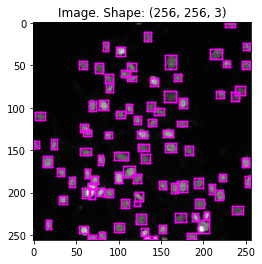

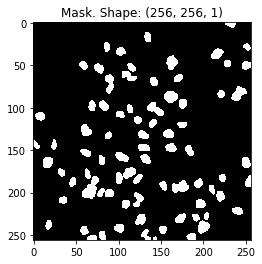

Validation set: 


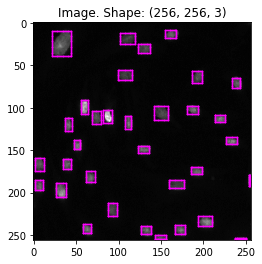

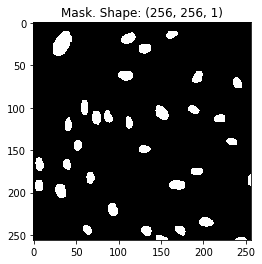

Testing set: 


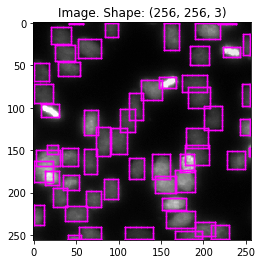

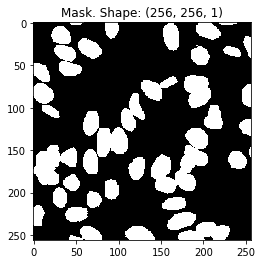

In [17]:
#Visualizing random images from the three sets 

print('Training set: ')
ch = np.random.randint(X_train.shape[0])
plt.imshow(X_train[ch,:,:,0] +X_train[ch,:,:,1]+X_train[ch,:,:,2], cmap = 'gray')
plt.title('Image. Shape: '+str(X_train[ch].shape))
draw_bb(D_train[ch])
plt.show()

plt.imshow(Y_train[ch,:,:,0],cmap = 'gray')
plt.title('Mask. Shape: '+str(Y_train[ch].shape))
plt.show()

print('Validation set: ')
ch = np.random.randint(X_val.shape[0])
plt.imshow(X_val[ch,:,:,0] +X_val[ch,:,:,1]+X_val[ch,:,:,2], cmap = 'gray')
plt.title('Image. Shape: '+str(X_val[ch].shape))
draw_bb(D_val[ch])
plt.show()

plt.imshow(Y_val[ch,:,:,0],cmap = 'gray')
plt.title('Mask. Shape: '+str(Y_val[ch].shape))
plt.show()

print('Testing set: ')
ch = np.random.randint(X_test.shape[0])
plt.imshow(X_test[ch,:,:,0] +X_test[ch,:,:,1]+X_test[ch,:,:,2], cmap = 'gray')
plt.title('Image. Shape: '+str(X_test[ch].shape))
draw_bb(D_test[ch])
plt.show()

plt.imshow(Y_test[ch,:,:,0],cmap = 'gray')
plt.title('Mask. Shape: '+str(Y_test[ch].shape))
plt.show()

In [18]:
#Saving data 
np.save('dataset/X_full.npy',X)
np.save('dataset/Y_full.npy',Y)
np.save('dataset/D_full.npy',D)

np.save('dataset/X_train.npy',X_train)
np.save('dataset/Y_train.npy',Y_train)
np.save('dataset/D_train.npy',D_train)

np.save('dataset/X_val.npy',X_val)
np.save('dataset/Y_val.npy',Y_val)
np.save('dataset/D_val.npy',D_val)

np.save('dataset/X_test.npy',X_test)
np.save('dataset/Y_test.npy',Y_test)
np.save('dataset/D_test.npy',D_test)

In [ ]:
#Code to load data

X_train  = np.load('dataset/X_train.npy')
Y_train  = np.load('dataset/Y_train.npy')
D_train  = np.load('dataset/D_train.npy')

X_val  = np.load('dataset/X_val.npy')
Y_val  = np.load('dataset/Y_val.npy')
D_val  = np.load('dataset/D_val.npy')

X_test  = np.load('dataset/X_test.npy')
Y_test  = np.load('dataset/Y_test.npy')
D_test  = np.load('dataset/D_test.npy')